# Modules

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Machine Learning Projects/Object Detection'

/content/drive/My Drive/Machine Learning Projects/Object Detection


In [0]:
import cv2
import torch
import torch.nn as nn
import torchvision

In [0]:
from PIL import Image

In [0]:
import torchvision.models as models

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt
from torchvision import transforms
%matplotlib inline

In [0]:
import os

In [0]:
from torchsummary import summary

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torch.optim as optim

In [0]:
from tqdm import tqdm_notebook as tqdm

# DataLoader

In [0]:
image_path = 'dataset/Image'
annotation_path = 'dataset/Annotation'

In [0]:
class DataLoader(Dataset):
    def __init__(self,image_path,annotation_path,transform=None,image_size = None,train=False):
        
        self.image_file = [files for _,_,files in os.walk(image_path)]
        self.image_file = [f for f in self.image_file[0]]
        self.annotation_file = [name[:name.rfind('.')]+'.txt' for name in self.image_file]
        self.transform = transform
        self.image_path = image_path
        self.annotation_path = annotation_path
        self.image_size = image_size

    def __len__(self):
        return len(self.annotation_file)

    def __getitem__(self, idx):

        img_name = self.image_path+'/'+self.image_file[idx]
#         print(img_name)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H = float(image.shape[0])
        W = float(image.shape[1])
        if self.image_size:
            image = cv2.resize(image, self.image_size,interpolation = cv2.INTER_AREA)

        f = open(self.annotation_path+'/'+self.annotation_file[idx])
        f.seek(0)
        bbox = []
        label = []
        for i in f:
            label.append(i.split(',')[-1].split(':')[-1].rstrip("\n\r"))
            bb = list(map(int,i.split(',')[:-1]))
            bb[:4] = [x/W for x in bb[:4]]
            bb[4:] = [x/H for x in bb[4:]]
            bb = [x*448 for x in bb]
            bb = list(map(int,bb))
            bbox.append(bb)
            
        if self.transform:
            image = self.transform(image)
            bbox = torch.Tensor(bbox)
            
        sample = {
            'image_name':img_name,
            'image': image, 
            'bbox':bbox,
            'label':label ,
            'original_size':(H,W)
        }


        return sample

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [0]:
dataLoader = DataLoader(image_path,annotation_path,image_size=(448,448),transform=transform)

# Image Visualization

In [0]:
def imshow(image):
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
    image = image * [0.5,0.5,0.5] + [0.5,0.5,0.5]
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.show()

In [0]:
def image_show_annotated(D,annot_thickness = 3):
    keys = D.keys()
    keys = list(keys)
    img_name = D[keys[0]]
    image = D[keys[1]].numpy()
    image = np.transpose(image,(1,2,0))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox = D[keys[2]].numpy()
    image = image * [0.5,0.5,0.5] + [0.5,0.5,0.5]
    image = np.clip(image,0,1)
    bbox = bbox.astype(int)
    label = D[keys[3]]
    for i,bb in enumerate(bbox):
        X1 = min(bb[0],bb[3])
        X2 = max(bb[1],bb[2])

        Y1 = min(bb[4],bb[5])
        Y2 = max(bb[6],bb[7])
        cv2.rectangle(image,(X1,Y1),(X2,Y2),(0,255,0),annot_thickness)
        cv2.putText(image,label[i], (bb[0],bb[4]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255),3,cv2.LINE_AA)
    plt.figure(figsize=(8,8))
    plt.title(img_name)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


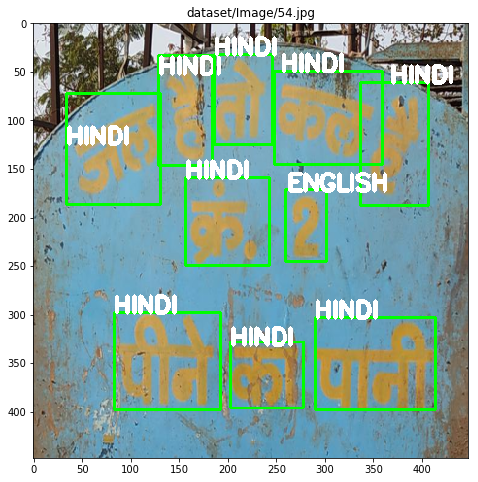

In [21]:
ind = np.random.randint(428)
# ind = 270
image_show_annotated(dataLoader[ind],annot_thickness = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 448, 448])
(3, 448, 448)


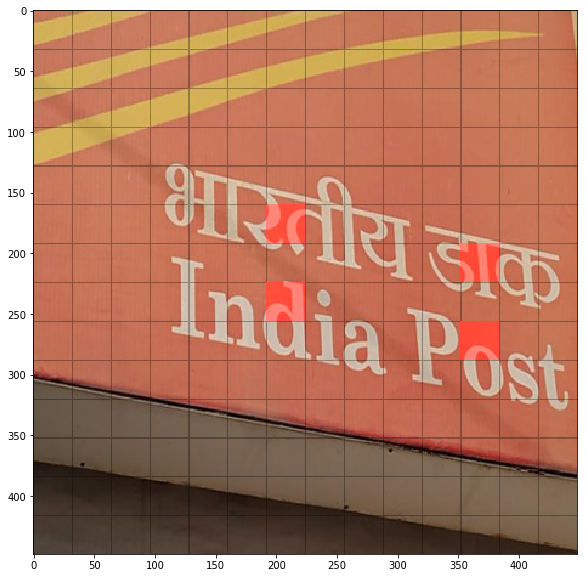

In [23]:
ind = np.random.randint(428)
data = dataLoader[ind]
image = data['image']
# imshow(image)
image = image.unsqueeze(0)
print(image.size())

step = int(448/14)
bbox = data['bbox']
truth = []
for bb in bbox:
    X1 = min(bb[0],bb[3])
    X2 = max(bb[1],bb[2])
    
    Y1 = min(bb[4],bb[5])
    Y2 = max(bb[6],bb[7])
    
    Xc = (X1+X2)/2
    Yc = (Y1+Y2)/2
    
    X = int(Xc/step)
    Y = int(Yc/step)
    truth.append((X,Y))
# print(truth)

image = torch.squeeze(image)
image = image.numpy()
print(image.shape)
image = np.transpose(image,(1,2,0))
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image * [0.5,0.5,0.5] + [0.5,0.5,0.5]

overlay = image.copy()


count = 0
for i in range(0,14):
    for j in range(0,14):
        x0,y0 = i*step,j*step
        x1,y1 = (i+1)*step,(j+1)*step
        xc,yc = int((x1+x0)/2),int((y1+y0)/2)
#         cv2.circle(image,(xc,yc),2,(0,0,255),-1)
#         print(xc,yc)
#         cv2.putText(image,str(count), (xc-10,yc), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0),1,cv2.LINE_AA)
        count+=1
        rgb = (0,0,0)
#         print(i,j)
        if (i,j) in truth:
            d = -1
            rgb=(255,0,0)
        else:
            d = 1
        cv2.rectangle(overlay,(x0,y0),(x1,y1),rgb,d)  
#         X = int(out[0,1,i,j]*448)
#         Y = int(out[0,2,i,j]*448)
#         H = int(out[0,3,i,j]*448)
#         W = int(out[0,4,i,j]*448)
#         cv2.rectangle(image,(X,Y),(X+H,Y+W),(0,255,0),1)
alpha = 0.3
cv2.addWeighted(overlay,alpha,image,1-alpha,0,image)               
plt.figure(figsize=(10,10))
plt.imshow(image)

In [0]:
dataL = torch.utils.data.DataLoader(dataLoader,batch_size = 1,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


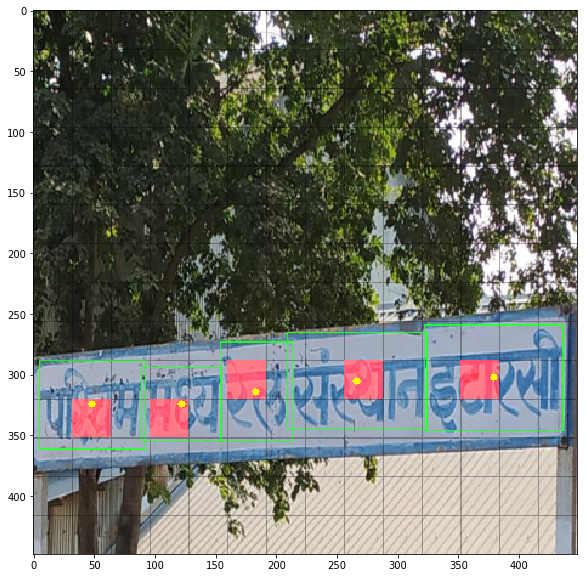

In [25]:
for i, data in enumerate(dataL):
    ground_truth = torch.zeros((1,5,14,14))
    step = int(448/14)
    bbox = data['bbox']
    truth = []

    for bb in bbox[0]:

        X1 = min(bb[0],bb[3])
        X2 = max(bb[1],bb[2])

        Y1 = min(bb[4],bb[5])
        Y2 = max(bb[6],bb[7])

        Xc = (X1+X2)/2
        Yc = (Y1+Y2)/2

        X = int(Xc/step)
        Y = int(Yc/step)
        truth.append((X,Y))

    for i in range(0,14):
        for j in range(0,14):
            x0,y0 = i*step,j*step
            x1,y1 = (i+1)*step,(j+1)*step
            if (i,j) in truth:
                ind = truth.index((i,j))
                X1 = min(bbox[0,ind,0],bbox[0,ind,3])
                X2 = max(bbox[0,ind,1],bbox[0,ind,2])

                Y1 = min(bbox[0,ind,4],bbox[0,ind,5])
                Y2 = max(bbox[0,ind,6],bbox[0,ind,7])

                ground_truth[0,0,i,j] = 1
                ground_truth[0,1,i,j] = X1/448
                ground_truth[0,2,i,j] = Y1/448
                ground_truth[0,3,i,j] = (Y2-Y1)/448
                ground_truth[0,4,i,j] = (X2-X1)/448


    image = data['image']            
    image = torch.squeeze(image)
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image * [0.5,0.5,0.5] + [0.5,0.5,0.5]

    overlay = image.copy()


    count = 0
    for i in range(0,14):
        for j in range(0,14):

            count+=1
            rgb = (0,0,0)
            if ground_truth[0,0,i,j]==1:
                d = -1
                rgb=(255,0,0)
                x1 = int(ground_truth[0,1,i,j].item()*448)
                y1 = int(ground_truth[0,2,i,j].item()*448)
                h = int(ground_truth[0,3,i,j].item()*448)
                w = int(ground_truth[0,4,i,j].item()*448)
                xc,yc = int((2*x1 + w)/2),int((2*y1 + h)/2)

                cv2.rectangle(image,(x1,y1),(x1+w,y1+h),(0,255,0),1)
                cv2.circle(image,(xc,yc),3,(0,255,0),-1)
            else:
                d = 1
            x0,y0 = i*step,j*step
            x1,y1 = (i+1)*step,(j+1)*step
            cv2.rectangle(overlay,(x0,y0),(x1,y1),rgb,d)  
    alpha = 0.3
    cv2.addWeighted(overlay,alpha,image,1-alpha,0,image)               
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    break
    


# Model

In [26]:
vgg19_bn = models.vgg19_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:22<00:00, 25169807.99it/s]


In [0]:
for param in vgg19_bn.parameters():
    param.requires_grad = False

In [28]:
vgg19_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
class ObjectDetectionModel(nn.Module):
    def __init__(self, model):
        super(ObjectDetectionModel,self).__init__()
        self.features = model.features
        self.avgpool = model.avgpool
        
        self.classifier = nn.Sequential(
            nn.Linear(25088,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 14*14*5),
            
        )
#         self.fc1 = model.classifier[0]
#         self.relu = model.classifier[1]
#         self.dropout = model.classifier[2]
#         self.fc2 = nn.Linear(4096,14*14*5)

        self.sigm = nn.Sigmoid()
        
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
        x = self.classifier(x)
        x = self.sigm(x)
        x = x.view(-1,5,14,14)
        
        return x

In [0]:
model = ObjectDetectionModel(vgg19_bn)

In [31]:
model

ObjectDetectionModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, k

In [32]:
count = 0
for param in model.parameters():
    count+=1
    if param.requires_grad == True:
        print("True")
print(count)

True
True
True
True
True
True
70


# Training

In [39]:
model.to(device)

ObjectDetectionModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, k

In [0]:
def yolo_loss(predicted,true):
  loss_confidence = torch.sum(true[0,0,:,:]*torch.pow(predicted[0,0,:,:]-true[0,0,:,:],2))
  loss_confidence += 0.5*torch.sum((1-true[0,0,:,:])*torch.pow(predicted[0,0,:,:]-true[0,0,:,:],2))
  
  loss_centers = 5*torch.sum(true[0,0,:,:]*torch.pow(predicted[0,1,:,:]-true[0,1,:,:],2))
  loss_centers += 5*torch.sum(true[0,0,:,:]*torch.pow(predicted[0,2,:,:]-true[0,2,:,:],2))
  
  loss_dimensions = 5*torch.sum(true[0,0,:,:]*torch.pow(torch.sqrt(predicted[0,3,:,:])-torch.sqrt(true[0,3,:,:]),2))
  loss_dimensions += 5*torch.sum(true[0,0,:,:]*torch.pow(torch.sqrt(predicted[0,4,:,:])-torch.sqrt(true[0,4,:,:]),2))
  
  return loss_confidence + loss_centers + loss_dimensions
                                
  

In [0]:
dataL = torch.utils.data.DataLoader(dataLoader,batch_size = 1,shuffle=True)

In [0]:
opt = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = yolo_loss

In [0]:
loss_arr = []

In [74]:
model.load_state_dict(torch.load('model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [80]:
total_epochs = 50
model.train()
for epoch in range(1,total_epochs+1): 
    loss_all = 0.0
    loss = 0
    for i, data in tqdm(enumerate(dataL),total=428,unit='image'):
        ground_truth = torch.zeros((1,5,14,14))
        step = int(448/14)
        bbox = data['bbox']
        truth = []
#         print(data['image_name'])
        for bb in bbox[0]:
           
            X1 = min(bb[0],bb[3])
            X2 = max(bb[1],bb[2])

            Y1 = min(bb[4],bb[5])
            Y2 = max(bb[6],bb[7])

            Xc = (X1+X2)/2
            Yc = (Y1+Y2)/2

            X = int(Xc/step)
            Y = int(Yc/step)
            truth.append((X,Y))
            
        for i in range(0,14):
            for j in range(0,14):
                x0,y0 = i*step,j*step
                x1,y1 = (i+1)*step,(j+1)*step
                if (i,j) in truth:
                    ind = truth.index((i,j))
                    X1 = min(bbox[0,ind,0],bbox[0,ind,3])
                    X2 = max(bbox[0,ind,1],bbox[0,ind,2])

                    Y1 = min(bbox[0,ind,4],bbox[0,ind,5])
                    Y2 = max(bbox[0,ind,6],bbox[0,ind,7])
                    
                    Xc, Yc = int((X1+X2)/2),int((Y1+Y2)/2)
                    
                    ground_truth[0,0,i,j] = 1
                    ground_truth[0,1,i,j] = (Xc-x0)/(x1-x0)
                    ground_truth[0,2,i,j] = (Yc-y0)/(y1-y0)
                    ground_truth[0,3,i,j] = (Y2-Y1)/448
                    ground_truth[0,4,i,j] = (X2-X1)/448
                    
        image = data['image']
        image = image.to(device)
        ground_truth=ground_truth.to(device)
        output = model(image)
        loss += loss_fn(output,ground_truth)
        loss_all+=loss.item()
        
    opt.zero_grad()
    loss = loss/len(dataL)
    loss.backward()
    opt.step()
    loss_arr.append(loss_all/len(dataL))
    print("Epoch: {}, Loss: {}".format(epoch,loss_all/len(dataL)))
    

Epoch: 1, Loss: 149.93101181089878


Epoch: 2, Loss: 156.35672923811128


Epoch: 3, Loss: 141.54430268252287


Epoch: 4, Loss: 132.3482246481091


Epoch: 5, Loss: 145.8033810608855


Epoch: 6, Loss: 140.88523325807998


Epoch: 7, Loss: 137.80466346498406


Epoch: 8, Loss: 141.95730072037082


Epoch: 9, Loss: 144.7508934039936


Epoch: 10, Loss: 137.64362941779822


KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(),'model.pth')

In [83]:
model.load_state_dict(torch.load('model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

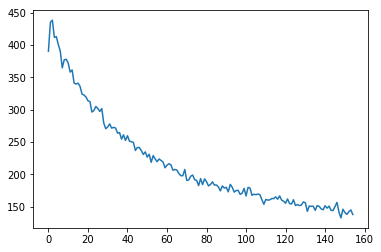

In [84]:
plt.plot(loss_arr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[3.3914e-04, 1.4768e-03, 1.2706e-03, 3.3518e-03, 2.3414e-03, 2.8677e-04,
         1.5131e-02, 5.8718e-03, 3.1451e-03, 1.9660e-03, 4.1933e-03, 4.6660e-03,
         2.6724e-04, 2.8464e-04],
        [3.4782e-04, 4.3749e-03, 4.6070e-03, 5.4143e-03, 6.7848e-03, 4.1273e-03,
         7.1470e-03, 5.0108e-03, 4.1137e-03, 2.4190e-02, 1.5538e-02, 1.8176e-02,
         4.9404e-03, 3.1531e-04],
        [3.1654e-04, 7.2415e-03, 1.1908e-02, 9.2878e-03, 1.9929e-03, 1.8529e-02,
         4.6258e-03, 2.4834e-02, 1.4688e-02, 9.0219e-03, 1.5868e-02, 8.5382e-03,
         1.9712e-02, 2.2130e-04],
        [2.7011e-04, 7.0537e-03, 2.0660e-03, 1.5139e-02, 1.6626e-03, 1.4794e-02,
         9.2416e-03, 8.6505e-03, 1.0237e-02, 2.5502e-02, 7.1801e-03, 2.7115e-02,
         6.5045e-03, 2.2642e-03],
        [9.8316e-04, 4.4086e-03, 3.5480e-03, 6.5074e-03, 6.2448e-03, 1.3858e-02,
         1.5129e-02, 8.5533e-03, 6.7945e-03, 6.3326e-03, 4.9429e-03, 2.4988e-02,
         2.4302e-02, 5.7549e-03],
        [2.0680e-04,

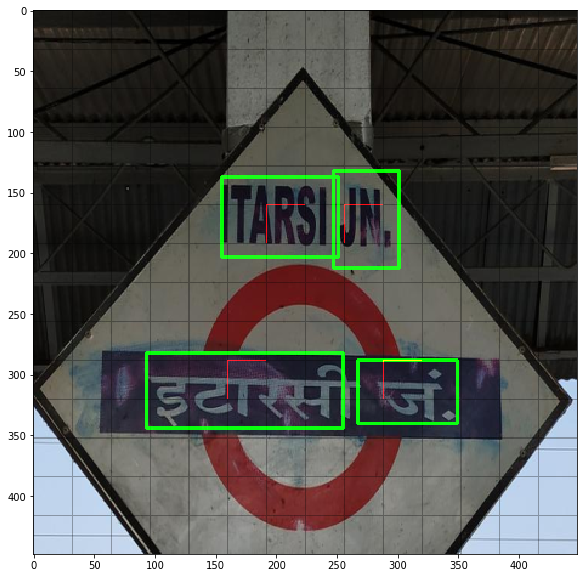

In [119]:
model.eval()
for i, data in enumerate(dataL):
    ground_truth = torch.zeros((1,5,14,14))
    step = int(448/14)
    bbox = data['bbox']
    truth = []

    for bb in bbox[0]:

        X1 = min(bb[0],bb[3])
        X2 = max(bb[1],bb[2])

        Y1 = min(bb[4],bb[5])
        Y2 = max(bb[6],bb[7])

        Xc = (X1+X2)/2
        Yc = (Y1+Y2)/2

        X = int(Xc/step)
        Y = int(Yc/step)
        truth.append((X,Y))

    for i in range(0,14):
        for j in range(0,14):
            x0,y0 = i*step,j*step
            x1,y1 = (i+1)*step,(j+1)*step
            if (i,j) in truth:
                ind = truth.index((i,j))
                X1 = min(bbox[0,ind,0],bbox[0,ind,3])
                X2 = max(bbox[0,ind,1],bbox[0,ind,2])

                Y1 = min(bbox[0,ind,4],bbox[0,ind,5])
                Y2 = max(bbox[0,ind,6],bbox[0,ind,7])

                ground_truth[0,0,i,j] = 1
                ground_truth[0,1,i,j] = X1/448
                ground_truth[0,2,i,j] = Y1/448
                ground_truth[0,3,i,j] = (Y2-Y1)/448
                ground_truth[0,4,i,j] = (X2-X1)/448


    image = data['image']
    image = image.to(device)
    output = model(image)
    output = output.detach().to("cpu")
    image = torch.squeeze(image).to("cpu")
    image = image.numpy()
    image = np.transpose(image,(1,2,0))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image * [0.5,0.5,0.5] + [0.5,0.5,0.5]

    overlay = image.copy()
    print(output[0,0,:,:])

    count = 0
    for i in range(0,14):
        for j in range(0,14):
            x0,y0 = i*step,j*step
            x1,y1 = (i+1)*step,(j+1)*step
            count+=1
            rgb = (0,0,0)
            if output[0,0,i,j]>=0.35:
              d = output[0,0,i,j]
              rgb=(255,0,0)
              XC = int(output[0,1,i,j].item()*(x1-x0)+x0)
              YC = int(output[0,2,i,j].item()*(y1-y0)+y0)
              H = int(output[0,3,i,j].item()*448)
              W = int(output[0,4,i,j].item()*448)
              
              cv2.rectangle(image,(XC-W//2,YC-H//2),(XC+W//2,YC+H//2),(0,255,0),2)

            x0,y0 = i*step,j*step
            x1,y1 = (i+1)*step,(j+1)*step
            cv2.rectangle(overlay,(x0,y0),(x1,y1),rgb,d)  
    alpha = 0.3
    cv2.addWeighted(overlay,alpha,image,1-alpha,0,image)               
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    break